<a href="https://colab.research.google.com/github/yuancx2025/526_project_group2/blob/main/ds_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airline Price Prediction Project

**TING ZHOU**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import random

csv_path = '/content/drive/MyDrive/itineraries_sample.csv'

flight_sample = pd.read_csv(csv_path)
flight_sample.head()

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeEpochSeconds,segmentsDepartureTimeRaw,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,0d654f1c4884897aff1c2ffb968e6e40,2022-10-05,2022-11-08,ORD,SFO,KAU4AKBS,PT7H57M,1,True,False,False,98.60,129.60,9,2084.0,1667952480||1667975760,2022-11-08T18:08:00.000-06:00||2022-11-08T22:3...,1667969040||1667981100,2022-11-08T20:44:00.000-08:00||2022-11-09T00:0...,LAX||SFO,ORD||LAX,United||United,UA||UA,Boeing 757-300||Airbus A320,16560||5340,1745||339,coach||coach
1,b0c2b8e7f41fd456ca95b41e00d9ce56,2022-10-05,2022-11-08,PHL,LAX,UAUTC2BC,PT9H19M,0,True,False,False,227.91,268.60,9,2564.0,1667903400||1667919840,2022-11-08T05:30:00.000-05:00||2022-11-08T10:0...,1667910900||1667936940,2022-11-08T07:35:00.000-05:00||2022-11-08T11:4...,ATL||ONT,PHL||ATL,Delta||Delta,DL||DL,Boeing 737-900||Airbus A321,7500||17100,667||1897,coach||coach
2,6b2e2224f5e8cec5f02e4a1221d405b9,2022-10-05,2022-11-11,PHL,DEN,PI7QBEL1,PT14H5M,0,False,False,False,199.08,247.71,7,2098.0,1668180420||1668203820||1668214800,2022-11-11T10:27:00.000-05:00||2022-11-11T16:5...,1668185040||1668208320||1668231120,2022-11-11T11:44:00.000-05:00||2022-11-11T18:1...,BOS||JFK||DEN,PHL||BOS||JFK,JetBlue Airways||JetBlue Airways||JetBlue Airways,B6||B6||B6,Airbus A320||Airbus A320||Airbus A320,4620||4500||16320,280||186||1632,coach||coach||coach
3,844531694368ca0ccd15d3fad4bf230d,2022-10-05,2022-11-10,DFW,SFO,TAA2JQBS,PT6H17M,0,True,False,False,143.26,177.61,9,1874.0,1668079500||1668086700,2022-11-10T05:25:00.000-06:00||2022-11-10T07:2...,1668083700||1668102120,2022-11-10T06:35:00.000-06:00||2022-11-10T09:4...,IAH||SFO,DFW||IAH,United||United,UA||UA,Boeing 737-700||Boeing 777,4200||15420,233||1641,coach||coach
4,bac03eeb6f097dd86d66d1c5438778fe,2022-10-05,2022-11-10,LAX,EWR,QAVTA0MC,PT8H39M,0,False,False,False,311.63,358.60,3,2653.0,1668092700||1668116160,2022-11-10T07:05:00.000-08:00||2022-11-10T16:3...,1668106680||1668123840,2022-11-10T13:58:00.000-05:00||2022-11-10T18:4...,ATL||EWR,ONT||ATL,Delta||Delta,DL||DL,Airbus A321||Boeing 737-800,13980||7680,1897||756,coach||coach


In [76]:
import pandas as pd

# classifying competitions
# columns used: startingAirport, destinationAirport, segmentsAirlineCode

#flights per route per airline
route_airline = (
    flight_sample
    .groupby(['startingAirport', 'destinationAirport', 'segmentsAirlineCode'])
    .size()
    .reset_index(name='count')
)

# market share within each route
route_airline['total_route'] = (
    route_airline.groupby(['startingAirport', 'destinationAirport'])['count']
    .transform('sum')
)
route_airline['share'] = route_airline['count'] / route_airline['total_route']

# Herfindahl–Hirschman Index (HHI)
hhi = (
    route_airline
    .groupby(['startingAirport', 'destinationAirport'])['share']
    .apply(lambda s: (s**2).sum())
    .reset_index(name='HHI')
)

# classifying market type
def classify(hhi_val):
    if hhi_val > 0.25:
        return 'Monopoly'
    elif hhi_val > 0.15:
        return 'Oligopoly'
    else:
        return 'Competitive'

hhi['MarketType'] = hhi['HHI'].apply(classify)

flight_sample = flight_sample.merge(hhi, on=['startingAirport', 'destinationAirport'], how='left')

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

print(hhi.head())


  startingAirport destinationAirport       HHI MarketType
0             ATL                BOS  0.157388  Oligopoly
1             ATL                CLT  0.249657  Oligopoly
2             ATL                DEN  0.167441  Oligopoly
3             ATL                DFW  0.163737  Oligopoly
4             ATL                DTW  0.155175  Oligopoly


In [77]:
# distribution of market types
market_counts = hhi['MarketType'].value_counts(normalize=True) * 100

print(market_counts.round(2).to_string())

MarketType
Oligopoly      67.52
Monopoly       17.09
Competitive    15.38


In [78]:
import pandas as pd
import numpy as np

BOOL_COLS = ['isBasicEconomy','isRefundable','isNonStop']
SEGMENT_COLS = [
    'segmentsDepartureTimeEpochSeconds','segmentsDepartureTimeRaw',
    'segmentsArrivalTimeEpochSeconds','segmentsArrivalTimeRaw',
    'segmentsArrivalAirportCode','segmentsDepartureAirportCode',
    'segmentsAirlineName','segmentsAirlineCode',
    'segmentsEquipmentDescription','segmentsDurationInSeconds',
    'segmentsDistance','segmentsCabinCode'
]

def _to_bool(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (bool, np.bool_)): return bool(x)
    if isinstance(x, (int, np.integer)) and x in (0,1): return bool(x)
    if isinstance(x, str):
        s = x.strip().lower()
        if s in ('1','true','t','yes','y'): return True
        if s in ('0','false','f','no','n'): return False
    return np.nan

def _count_legs(val):
    if pd.isna(val) or val=='':
        return 0
    return str(val).count('||') + 1

def _median(x):
    try: return np.nanmedian(x)
    except: return np.nan

# uniqueness check
def check_duplicates(df):
    total = len(df)
    uniq = df['legId'].nunique(dropna=False)
    dups = total - uniq
    print(f"[Duplicates] rows={total:,}, unique_legId={uniq:,}, duplicates={dups:,}")
    return {"rows": total, "unique_legId": uniq, "duplicates": dups}

# value check (check if entry type is valid)
def check_fares_bools_seats(df):
    base = pd.to_numeric(df['baseFare'], errors='coerce')
    total = pd.to_numeric(df['totalFare'], errors='coerce')

    v_base_pos = np.sum(~(base > 0))
    v_order    = np.sum(~(base <= total))
    print(f"[Fares] invalid base>0: {v_base_pos:,} | base<=total violated: {v_order:,}")

    out = {"fare_invalid_base>0": int(v_base_pos), "fare_order_violations": int(v_order)}

    # columns with boolean values
    bool_df = df[BOOL_COLS].applymap(_to_bool)
    invalid_bool = bool_df.isna().sum().to_dict()
    print("[Booleans] invalid counts:", invalid_bool)
    out["invalid_booleans"] = invalid_bool

    # seats(positive)
    seats = pd.to_numeric(df['seatsRemaining'], errors='coerce')
    neg = np.sum(seats < 0)
    nonint = np.sum(~seats.isna() & (seats % 1 != 0))
    desc = seats.describe()
    print(f"[Seats] negative={neg:,}, non-integer={nonint:,}")
    print(desc.to_string())
    out.update({"seats_negative": int(neg), "seats_nonint": int(nonint), "seats_desc": desc.to_dict()})
    return out

# time integrity(check for timeline violation)
def check_times(df):
    sd = pd.to_datetime(df['searchDate'], errors='coerce')
    fd = pd.to_datetime(df['flightDate'], errors='coerce')

    unparsable_sd = sd.isna().sum()
    unparsable_fd = fd.isna().sum()
    print(f"[Time] unparsable searchDate={unparsable_sd:,}, flightDate={unparsable_fd:,}")

    order_viol = np.sum(sd > fd)
    print(f"[Time] searchDate > flightDate violations: {order_viol:,}")

    book_win = (fd - sd).dt.days
    bw_desc = book_win.describe()
    neg = np.sum(book_win < 0)
    huge = np.sum(book_win > 365)
    print(f"[Booking window] negative={neg:,}, >365d={huge:,}")
    print(bw_desc.to_string())

    return {
        "unparsable_searchDate": int(unparsable_sd),
        "unparsable_flightDate": int(unparsable_fd),
        "order_violations": int(order_viol),
        "booking_window_desc": bw_desc.to_dict(),
        "booking_window_negative": int(neg),
        "booking_window_gt365": int(huge)
    }

# segment consistency (making sure they're connected)
def check_segments(df):
    leg_counts = {}
    for c in SEGMENT_COLS:
        if c in df.columns:
            leg_counts[c] = df[c].apply(_count_legs)
    legc = pd.DataFrame(leg_counts)

    # mismatch rows: max != min across segment fields (ignore missing columns)
    if legc.shape[1] == 0:
        print("[Segments] No segment columns found.")
        return {"segment_mismatch_rows": None}

    mismatch = (legc.max(axis=1) != legc.min(axis=1))
    mismatch_pct = 100 * mismatch.mean()
    print(f"[Segments] mismatched leg counts: {mismatch.sum():,} rows ({mismatch_pct:.2f}%)")

    # endpoint coherence (only if codes exist)
    endpoint_mismatch = None
    if 'segmentsDepartureAirportCode' in df.columns and 'segmentsArrivalAirportCode' in df.columns:
        dep_first = df['segmentsDepartureAirportCode'].str.split(r'\|\|').str[0]
        arr_last  = df['segmentsArrivalAirportCode'].str.split(r'\|\|').str[-1]
        m1 = (dep_first != df['startingAirport']).fillna(True)
        m2 = (arr_last  != df['destinationAirport']).fillna(True)
        endpoint_mismatch = {"start_code_mismatch": int(m1.sum()), "dest_code_mismatch": int(m2.sum())}
        print(f"[Segments] endpoint mismatches -> start:{m1.sum():,}, dest:{m2.sum():,}")

    return {
        "segment_mismatch_rows": int(mismatch.sum()),
        "endpoint_mismatch": endpoint_mismatch
    }

# make sure duration&distance align with the sum of segments
def check_duration_distance(df):
    out = {}

    # Nonstop coherence
    legs = df.get('segmentsDepartureTimeRaw', pd.Series(index=df.index)).apply(_count_legs)
    nonstop = df['isNonStop'].apply(_to_bool)
    contradiction = np.sum((nonstop == True) & (legs > 1))
    print(f"[Nonstop] contradictions (nonstop but legs>1): {contradiction:,}")
    out["nonstop_contradictions"] = int(contradiction)

    # Totals vs segment sums (if available)
    if 'segmentsDurationInSeconds' in df.columns and 'travelDuration' in df.columns:
        # normalize travelDuration to seconds if it's like "hh:mm"
        td = df['travelDuration'].astype(str)
        td_sec = pd.to_timedelta(td.where(td.str.contains(':'), np.nan), errors='coerce').dt.total_seconds()

        seg_sum = df['segmentsDurationInSeconds'].apply(
            lambda s: np.nansum(pd.to_numeric(str(s).split('||'), errors='coerce')) if pd.notna(s) else np.nan
        )
        delta = (td_sec - seg_sum)
        tol = 0.1 * seg_sum  # 10% tolerance
        bad = np.sum(~delta.isna() & (delta.abs() > tol.fillna(np.inf)))
        print(f"[Duration] total vs segments diff >10%: {bad:,}")
        out["duration_diff_gt10pct"] = int(bad)

    if 'segmentsDistance' in df.columns and 'totalTravelDistance' in df.columns:
        ttd = pd.to_numeric(df['totalTravelDistance'], errors='coerce')
        segd = df['segmentsDistance'].apply(
            lambda s: np.nansum(pd.to_numeric(str(s).split('||'), errors='coerce')) if pd.notna(s) else np.nan
        )
        dlt = (ttd - segd)
        tol = 0.1 * segd
        bad = np.sum(~dlt.isna() & (dlt.abs() > tol.fillna(np.inf)))
        print(f"[Distance] total vs segments diff >10%: {bad:,}")
        out["distance_diff_gt10pct"] = int(bad)

    return out

# check if there's abnormal pricing based on featuers
def check_price_coherence(df):
    out = {}
    total = pd.to_numeric(df['totalFare'], errors='coerce')

    # Refundable uplift
    ref = df['isRefundable'].apply(_to_bool)
    med_ref = _median(total[ref==True])
    med_non = _median(total[ref==False])
    uplift = med_ref - med_non
    print(f"[Refundable] median(ref)={med_ref:.2f}, median(non)={med_non:.2f}, uplift={uplift:.2f}")
    out["refundable_median_uplift"] = float(uplift)

    # Nonstop premium
    ns = df['isNonStop'].apply(_to_bool)
    med_ns  = _median(total[ns==True])
    med_con = _median(total[ns==False])
    prem = med_ns - med_con
    print(f"[Nonstop] median(nonstop)={med_ns:.2f}, median(connecting)={med_con:.2f}, premium={prem:.2f}")
    out["nonstop_median_premium"] = float(prem)

    # Cabin ladder (if any)
    if 'segmentsCabinCode' in df.columns:
        ladder = total.groupby(df['segmentsCabinCode']).median().sort_values()
        print("[Cabin] median ladder:\n", ladder.to_string())
        out["cabin_median_ladder"] = ladder.to_dict()

    return out

# missing data
def check_missingness(df):
    miss = df.isna().mean().sort_values(ascending=False) * 100
    print("[Missingness %] top columns:")
    print(miss.head(15).round(2).to_string())
    return {"missing_pct": miss.to_dict()}

# market type distribution
def check_hhi(df):
    # airline competition at route level
    grp = (df.groupby(['startingAirport','destinationAirport','segmentsAirlineCode'])
             .size().reset_index(name='count'))
    grp['route_total'] = grp.groupby(['startingAirport','destinationAirport'])['count'].transform('sum')
    grp['share'] = grp['count'] / grp['route_total']
    hhi = grp.groupby(['startingAirport','destinationAirport'])['share'].apply(lambda s: (s**2).sum()).reset_index(name='HHI')

    def classify(x):
        if x > 0.25: return 'Monopoly'
        elif x > 0.15: return 'Oligopoly'
        else: return 'Competitive'
    hhi['MarketType'] = hhi['HHI'].apply(classify)

    pct = (hhi['MarketType'].value_counts(normalize=True) * 100).round(2)
    print("[HHI] % by MarketType:\n", pct.to_string())
    return {"hhi": hhi, "markettype_pct": pct.to_dict()}

# pricing outliers
def check_outliers(df):
    total = pd.to_numeric(df['totalFare'], errors='coerce')
    q1, q3 = np.nanpercentile(total, [25, 75])
    iqr = q3 - q1
    lo, hi = q1 - 3*iqr, q3 + 3*iqr # flagging price outside this range
    outliers = np.sum((total < lo) | (total > hi))
    print(f"[Outliers] totalFare outside [Q1-3*IQR, Q3+3*IQR]: {outliers:,}")
    return {"price_outliers": int(outliers), "bounds": {"low": float(lo), "high": float(hi)}}

# preprocessing
def pre_checks(flight_sample: pd.DataFrame):
    results = {}
    print("\n1) Duplicates")
    results["duplicates"] = check_duplicates(flight_sample)

    print("\n2) Fares, Booleans, Seats Validity")
    results["fares_bools_seats"] = check_fares_bools_seats(flight_sample)

    print("\n3) Time Integrity")
    results["time"] = check_times(flight_sample)

    print("\n4) Segment Consistency")
    results["segments"] = check_segments(flight_sample)

    print("\n5) Duration & Distance Alignment")
    results["dur_dist"] = check_duration_distance(flight_sample)

    print("\n6) Price–Feature Coherence ")
    results["price_coherence"] = check_price_coherence(flight_sample)

    print("\n7) Missingness of entries")
    results["missingness"] = check_missingness(flight_sample)

    print("\n8) Coverage & HHI ")
    results["hhi"] = check_hhi(flight_sample)

    print("\n9) Outliers")
    results["outliers"] = check_outliers(flight_sample)

    return results

results = pre_checks(flight_sample)



1) Duplicates
[Duplicates] rows=20,000, unique_legId=20,000, duplicates=0

2) Fares, Booleans, Seats Validity
[Fares] invalid base>0: 0 | base<=total violated: 0
[Booleans] invalid counts: {'isBasicEconomy': 0, 'isRefundable': 0, 'isNonStop': 0}
[Seats] negative=0, non-integer=0
count    20000.000000
mean         6.742750
std          2.588495
min          0.000000
25%          7.000000
50%          7.000000
75%          9.000000
max         10.000000

3) Time Integrity
[Time] unparsable searchDate=0, flightDate=0
[Time] searchDate > flightDate violations: 0
[Booking window] negative=0, >365d=0
count    20000.000000
mean        33.194850
std          4.860387
min          1.000000
25%         31.000000
50%         35.000000
75%         36.000000
max         44.000000

4) Segment Consistency


/tmp/ipython-input-2070067333.py:54: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



[Segments] mismatched leg counts: 564 rows (2.82%)
[Segments] endpoint mismatches -> start:424, dest:491

5) Duration & Distance Alignment
[Nonstop] contradictions (nonstop but legs>1): 0
[Duration] total vs segments diff >10%: 0
[Distance] total vs segments diff >10%: 57

6) Price–Feature Coherence 
[Refundable] median(ref)=nan, median(non)=218.60, uplift=nan
[Nonstop] median(nonstop)=158.60, median(connecting)=245.60, premium=-87.00
[Cabin] median ladder:
 segmentsCabinCode
coach                           158.600
coach||coach                    221.600
coach||first                    278.100
coach||premium coach            451.600
coach||coach||coach||coach      519.290
coach||coach||coach             521.400
premium coach||coach            672.095
coach||coach||premium coach     703.090
premium coach                   998.600
first||first                   1609.600
first                          2057.610
first||coach                   2157.600
business||business             2697.200

/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning:

Mean of empty slice



Remark: The dataset is overall clean and reliable. It includes 20,000 unique flight records with no duplicates and valid entries across fares, booleans, and seat counts. Seat availability averages around seven per flight, suggesting data were collected at reasonable booking stages.

Time information is fully consistent: all dates are valid, and every search precedes its flight. The booking window averages about 33 days, reflecting realistic traveler behavior.

Segment data are largely coherent, with only about 3% showing mismatched leg counts or minor endpoint errors—small enough not to affect overall trends. Duration and distance fields also align well: total and segment-level sums agree almost perfectly, and non-stop indicators match the number of legs.

In pricing patterns, refundable fares are mostly missing, while non-stop flights are unexpectedly cheaper than connecting ones—likely due to strong competition on direct, high-demand routes. Cabin-level pricing follows expected order, with prices rising from coach to business class.

Missingness is minimal aside from totalTravelDistance, which is absent in roughly 11% of rows. Outliers are rare (about 1.2% of fares), suggesting stable and realistic price ranges.

Market structure analysis shows that most routes are oligopolistic (about two-thirds), with fewer monopoly and competitive cases. This confirms the dataset’s bias toward major, high-traffic routes, limiting representativeness for smaller markets.

Overall, the data are clean and well-behaved, suitable for modeling price behavior. Remaining issues—minor segment mismatches, limited refundable data, and route concentration—are modest and can be handled easily in preprocessing.

In [79]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

#plotting routes by market type on map
routes = hhi.copy()
routes.rename(columns={'startingAirport':'orig', 'destinationAirport':'dest'}, inplace=True)

# sample to avoid clutter on the map
n = 500
if len(routes) > n:
    # stratified sample by MarketType so each class is represented
    routes = (routes.groupby('MarketType', group_keys=False)
                    .apply(lambda g: g.sample(min(len(g), max(1, n // 3)), random_state=42))
                    .reset_index(drop=True))

# load airport coordinates (IATA -> lat/lon)
airports_raw = pd.read_csv(
    "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat",
    header=None
)
airports = airports_raw[[1, 2, 3, 4, 5, 6, 7, 8, 9]]
airports.columns = ["airport_name", "city", "country", "iata", "ICAO", "lat", "lon", "alt", "timezone"]

airports = airports[['iata','lat','lon']].dropna().drop_duplicates()

# merge src coords
routes = routes.merge(airports.add_prefix('orig_'), left_on='orig', right_on='orig_iata', how='inner')
# dest coords
routes = routes.merge(airports.add_prefix('dest_'), left_on='dest', right_on='dest_iata', how='inner')

# keep relevant columns
routes = routes[['orig','dest','MarketType','orig_lat','orig_lon','dest_lat','dest_lon']]


color_map = {
    'Monopoly':  '#d62728',  # red
    'Oligopoly': '#1f77b4',  # blue
    'Competitive':'#2ca02c'  # green
}

fig = go.Figure()

# add line segments per MarketType
for mt, g in routes.groupby('MarketType'):

    lats = []
    lons = []
    for _, row in g.iterrows():
        lats += [row['orig_lat'], row['dest_lat'], None]
        lons += [row['orig_lon'], row['dest_lon'], None]

    fig.add_trace(go.Scattergeo(
        lat=lats, lon=lons,
        mode='lines',
        line=dict(width=1.2, color=color_map.get(mt, '#666')),
        name=mt,
        hoverinfo='skip'
    ))

# add airport nodes for hover context (origins + destinations)
nodes = pd.DataFrame({
    'iata': pd.concat([routes['orig'], routes['dest']], ignore_index=True),
    'lat':  pd.concat([routes['orig_lat'], routes['dest_lat']], ignore_index=True),
    'lon':  pd.concat([routes['orig_lon'], routes['dest_lon']], ignore_index=True)
}).drop_duplicates()

fig.add_trace(go.Scattergeo(
    lat=nodes['lat'],
    lon=nodes['lon'],
    mode='markers',
    marker=dict(size=3),
    text=nodes['iata'],
    hovertemplate="<b>%{text}</b><extra></extra>",
    name='Airports'
))

fig.update_geos(
    scope='north america',
    projection_type='albers usa',
    showcountries=True, showland=True, landcolor='rgb(240,240,240)',
    lakecolor='rgb(255,255,255)'
)

fig.update_layout(
    title='Sampled US Flight Routes by Market Structure',
    legend=dict(orientation='h', y=1.05, x=0),
    margin=dict(l=0, r=0, t=60, b=0)
)

fig.show()


In [80]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score


# apply ridge regression
# preprocessing summary: applied type conversion and added
# 1. booking windows(number of days between searchDate and flightDate),
# 2. num_legs(count of flight segments per trip),
# 3. route_distance
# 4. log price as target

df = flight_sample.copy()

# dates & booking window
df['searchDate'] = pd.to_datetime(df['searchDate'], errors='coerce')
df['flightDate'] = pd.to_datetime(df['flightDate'], errors='coerce')
df = df.dropna(subset=['searchDate','flightDate','totalFare'])
df['booking_window'] = (df['flightDate'] - df['searchDate']).dt.days.clip(lower=0, upper=365)

# legs count
def _count_legs(s):
    if pd.isna(s) or s == '': return 0
    return str(s).count('||') + 1
src_col = 'segmentsDepartureTimeRaw' if 'segmentsDepartureTimeRaw' in df.columns else (
          'segmentsDepartureTimeEpochSeconds' if 'segmentsDepartureTimeEpochSeconds' in df.columns else None)
df['num_legs'] = df[src_col].apply(_count_legs) if src_col else 1  # fallback: 1

# route distance (totalTravelDistance else sum(segmentsDistance))
def _sum_segments_nums(s):
    if pd.isna(s): return np.nan
    return np.nansum(pd.to_numeric(str(s).split('||'), errors='coerce'))
df['route_distance'] = pd.to_numeric(df.get('totalTravelDistance', np.nan), errors='coerce')
if 'segmentsDistance' in df.columns:
    seg_dist = df['segmentsDistance'].apply(_sum_segments_nums)
    df['route_distance'] = df['route_distance'].fillna(seg_dist)
# winsorization
if df['route_distance'].notna().any():
    q1, q99 = df['route_distance'].quantile([0.01, 0.99])
    df['route_distance'] = df['route_distance'].clip(lower=q1, upper=q99)

# clean booleans & seats
for c in ['isNonStop','isRefundable','isBasicEconomy']:
    if c in df.columns:
        df[c] = df[c].astype(int)
df['seatsRemaining'] = pd.to_numeric(df['seatsRemaining'], errors='coerce')

# targe:log price
df = df[df['totalFare'].notna() & (df['totalFare'] > 0)]
df['log_price'] = np.log(df['totalFare'])

# features
num_feats = ['booking_window', 'route_distance', 'num_legs', 'seatsRemaining']
cat_feats = [c for c in ['startingAirport','destinationAirport','segmentsAirlineCode',
                         'isNonStop','isRefundable','isBasicEconomy'] if c in df.columns]

missing_now = [c for c in num_feats + cat_feats if c not in df.columns]
assert not missing_now, f"Missing expected columns: {missing_now}"

X = df[num_feats + cat_feats]
y = df['log_price']

# time-based split
df_sorted_idx = df.sort_values('flightDate').index
cut = int(len(df_sorted_idx) * 0.8)
train_idx, test_idx = df_sorted_idx[:cut], df_sorted_idx[cut:]
X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_test,  y_test  = X.loc[test_idx],  y.loc[test_idx]

# pipeline with imputers (ridgeregression cant deal with nan)
pre = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('impute', SimpleImputer(strategy='median')),
                          ('scale', StandardScaler())]), num_feats),
        ('cat', Pipeline([('impute', SimpleImputer(strategy='most_frequent')),
                          ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))]), cat_feats)
    ]
)

alphas = np.logspace(-3, 3, 40)
ridge = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_absolute_error')
pipe = Pipeline([('pre', pre), ('ridge', ridge)])
pipe.fit(X_train, y_train)

pred_tr = pipe.predict(X_train); pred_te = pipe.predict(X_test)
print("alpha_*:", pipe.named_steps['ridge'].alpha_)
print("Train R2:", round(r2_score(y_train, pred_tr), 3), "Test R2:", round(r2_score(y_test, pred_te), 3))


alpha_*: 0.024244620170823284
Train R2: 0.692 Test R2: 0.635


inspect model

In [81]:
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np, pandas as pd

pred_tr = pipe.predict(X_train); pred_te = pipe.predict(X_test)

def mape(y_true, y_pred):
    yt, yp = np.exp(y_true), np.exp(y_pred)
    return np.mean(np.abs((yt-yp)/yt))*100

print({
    "alpha_*": pipe.named_steps['ridge'].alpha_,
    "Train_R2": r2_score(y_train, pred_tr),
    "Test_R2":  r2_score(y_test,  pred_te),
    "Test_MAE_$": float(np.median(np.abs(np.exp(y_test)-np.exp(pred_te)))),
    "Test_MAPE_%": mape(y_test, pred_te)
})

# Top coefficients
ohe = pipe.named_steps['pre'].named_transformers_['cat'].named_steps['ohe']
feat_names = (['booking_window','route_distance','num_legs','seatsRemaining']
              + list(ohe.get_feature_names_out(pipe.named_steps['pre'].transformers_[1][2])))
coefs = pd.DataFrame({"feature": feat_names, "coef": pipe.named_steps['ridge'].coef_})
print("Top +:", coefs.sort_values('coef', ascending=False).head(10).to_string(index=False))
print("Top -:", coefs.sort_values('coef').head(10).to_string(index=False))


{'alpha_*': np.float64(0.024244620170823284), 'Train_R2': 0.6919627216291055, 'Test_R2': 0.6345272714994019, 'Test_MAE_$': 45.53392853435352, 'Test_MAPE_%': np.float64(25.260939628595764)}
Top +:                            feature     coef
        segmentsAirlineCode_HA||HA 0.806894
segmentsAirlineCode_DL||9K||9K||9K 0.737400
        segmentsAirlineCode_9K||9K 0.684974
segmentsAirlineCode_DL||9K||9K||UA 0.557544
    segmentsAirlineCode_9K||9K||AA 0.549364
        segmentsAirlineCode_DL||UA 0.533293
        segmentsAirlineCode_UA||DL 0.524533
    segmentsAirlineCode_DL||AS||UA 0.502628
    segmentsAirlineCode_9K||9K||UA 0.451533
    segmentsAirlineCode_B6||9K||9K 0.439667
Top -:                            feature      coef
        segmentsAirlineCode_F9||F9 -0.956444
            segmentsAirlineCode_NK -0.884544
            segmentsAirlineCode_F9 -0.824417
    segmentsAirlineCode_F9||F9||F9 -0.787824
    segmentsAirlineCode_B6||B6||B6 -0.717014
    segmentsAirlineCode_LF||LF||AA -0.64204

too many coefficients and predictors in this case. simplify features next.

In [83]:
import numpy as np
import pandas as pd
from collections import Counter

from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error

df = flight_sample.copy()

# dates & booking window
df['searchDate'] = pd.to_datetime(df['searchDate'], errors='coerce')
df['flightDate'] = pd.to_datetime(df['flightDate'], errors='coerce')
df = df.dropna(subset=['searchDate','flightDate','totalFare'])
df['booking_window'] = (df['flightDate'] - df['searchDate']).dt.days.clip(lower=0, upper=365)

# legs count
def _count_legs(s):
    if pd.isna(s) or s == '': return 0
    return str(s).count('||') + 1

src_col = 'segmentsDepartureTimeRaw' if 'segmentsDepartureTimeRaw' in df.columns else (
          'segmentsDepartureTimeEpochSeconds' if 'segmentsDepartureTimeEpochSeconds' in df.columns else None)
df['num_legs'] = df[src_col].apply(_count_legs) if src_col else 1  # fallback: 1

# route distance (totalTravelDistance else sum(segmentsDistance))
def _sum_segments_nums(s):
    if pd.isna(s): return np.nan
    return np.nansum(pd.to_numeric(str(s).split('||'), errors='coerce'))

df['route_distance'] = pd.to_numeric(df.get('totalTravelDistance', np.nan), errors='coerce')
if 'segmentsDistance' in df.columns:
    seg_dist = df['segmentsDistance'].apply(_sum_segments_nums)
    df['route_distance'] = df['route_distance'].fillna(seg_dist)
# winsorization
if df['route_distance'].notna().any():
    q1, q99 = df['route_distance'].quantile([0.01, 0.99])
    df['route_distance'] = df['route_distance'].clip(lower=q1, upper=q99)

# clean booleans & seats
for c in ['isNonStop','isRefundable','isBasicEconomy']:
    if c in df.columns:
        df[c] = df[c].astype(int)
df['seatsRemaining'] = pd.to_numeric(df['seatsRemaining'], errors='coerce')

# target: log price
df = df[df['totalFare'].notna() & (df['totalFare'] > 0)]
df['log_price'] = np.log(df['totalFare'])

# compact carrier features (instead of one-hotting the full combo)
def parse_carriers(s):
    if pd.isna(s) or s == '': return []
    return [tok.strip() for tok in str(s).split('||') if tok.strip()]

ULCC = {'NK','F9','G4'}               # ultra low-cost
LCC  = {'WN','B6','AS'}               # low-cost-ish

df['carriers_list'] = df.get('segmentsAirlineCode', pd.Series(index=df.index, dtype=object)).apply(parse_carriers)

df['first_carrier']      = df['carriers_list'].apply(lambda xs: xs[0] if xs else np.nan)
df['last_carrier']       = df['carriers_list'].apply(lambda xs: xs[-1] if xs else np.nan)
df['n_unique_carriers']  = df['carriers_list'].apply(lambda xs: len(set(xs)))
df['n_carrier_changes']  = (df['carriers_list'].apply(lambda xs: max(len(xs)-1,0))).astype(int)
df['has_ulcc']           = df['carriers_list'].apply(lambda xs: int(any(c in ULCC for c in xs)))
df['has_lcc']            = df['carriers_list'].apply(lambda xs: int(any(c in LCC  for c in xs)))

# time-based split
df_sorted_idx = df.sort_values('flightDate').index
cut = int(len(df_sorted_idx) * 0.8)
train_idx, test_idx = df_sorted_idx[:cut], df_sorted_idx[cut:]

# choose top-M individual carriers from TRAIN ONLY to avoid leakage
M = 8  # tune if you want more/less
train_carriers_flat = [c for xs in df.loc[train_idx, 'carriers_list'] for c in xs]
topM = [c for c,_ in Counter(train_carriers_flat).most_common(M)]

# binary presence flags for those top carriers (both train/test use same topM)
for c in topM:
    col = f'has_{c}'
    df[col] = df['carriers_list'].apply(lambda xs, cc=c: int(cc in xs))

# build feature matrix
base_num = ['booking_window', 'route_distance', 'num_legs', 'seatsRemaining',
            'n_unique_carriers', 'n_carrier_changes']
base_cat = [c for c in ['startingAirport','destinationAirport','isNonStop','isRefundable','isBasicEconomy',
                        'first_carrier','last_carrier'] if c in df.columns]

presence_cols = [f'has_{c}' for c in topM] + ['has_ulcc','has_lcc']

X_cols = base_num + presence_cols + base_cat
missing_now = [c for c in X_cols if c not in df.columns]
assert not missing_now, f"Missing expected columns: {missing_now}"

X = df[X_cols]
y = df['log_price']

X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_test,  y_test  = X.loc[test_idx],  y.loc[test_idx]

num_feats = base_num + presence_cols            # presence flags are numeric already
cat_feats = base_cat

pre = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('impute', SimpleImputer(strategy='median')),
            ('scale', StandardScaler())
        ]), num_feats),
        # OneHot only for low-cardinality cats; also collapse very rare levels automatically
        ('cat', Pipeline([
            ('impute', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore',
                                  sparse_output=True,
                                  min_frequency=50,        # collapse rare codes
                                  # or use max_categories=40 to hard-cap if you prefer
                                  ))
        ]), cat_feats),
    ],
    remainder='drop'
)

alphas = np.logspace(-3, 3, 40)
ridge = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_absolute_error')
pipe = Pipeline([('pre', pre), ('ridge', ridge)])

pipe.fit(X_train, y_train)

pred_tr = pipe.predict(X_train)
pred_te = pipe.predict(X_test)

out = {
    "alpha_*": pipe.named_steps['ridge'].alpha_,
    "Train_R2": r2_score(y_train, pred_tr),
    "Test_R2": r2_score(y_test, pred_te),
    "Test_MAE_$": (np.exp(y_test) - np.exp(pred_te)).abs().mean(),  # ← parentheses fixed
    "Test_MAPE_%": ((np.exp(pred_te) - np.exp(y_test)).abs() / np.exp(y_test)).mean() * 100,
    "topM_carriers_used": topM
}
print(out)


{'alpha_*': np.float64(0.001), 'Train_R2': 0.6661796649907059, 'Test_R2': 0.6105530652969802, 'Test_MAE_$': np.float64(70.24395398856302), 'Test_MAPE_%': np.float64(26.507298474000752), 'topM_carriers_used': ['AA', 'UA', 'DL', 'B6', 'AS', 'NK', 'F9', '9K']}


In [85]:
from collections import Counter

train_carriers_flat = [c for xs in df.loc[train_idx, 'carriers_list'] for c in xs]
pd.Series(Counter(train_carriers_flat)).sort_values(ascending=False).head(20)


,0
AA,8191
UA,8027
DL,6931
B6,2431
AS,2243
NK,1711
F9,511
9K,78
SY,56
9X,23


In [87]:
ridge_model = pipe.named_steps['ridge']
# Retrieve feature names from ColumnTransformer
num_names = pipe.named_steps['pre'].named_transformers_['num'].get_feature_names_out()
cat_names = pipe.named_steps['pre'].named_transformers_['cat'].get_feature_names_out()

feature_names = np.concatenate([num_names, cat_names])
coefs = pd.Series(ridge_model.coef_, index=feature_names)
coefs_sorted = coefs.sort_values(ascending=False)
print("Top + coefficients:")
print(coefs_sorted.head(10))

print("\nTop - coefficients:")
print(coefs_sorted.tail(10))
print("Best alpha:", ridge_model.alpha_)
print("Intercept:", ridge_model.intercept_)
print("Train R²:", r2_score(y_train, pipe.predict(X_train)))
print("Test R²:", r2_score(y_test, pipe.predict(X_test)))


Top + coefficients:
last_carrier_infrequent_sklearn     0.473110
has_UA                              0.435240
has_DL                              0.358448
isBasicEconomy_0                    0.322097
has_AA                              0.305667
first_carrier_AS                    0.200006
last_carrier_AA                     0.151080
first_carrier_infrequent_sklearn    0.148791
destinationAirport_OAK              0.138746
route_distance                      0.121419
dtype: float64

Top - coefficients:
startingAirport_BOS      -0.103549
first_carrier_UA         -0.142295
last_carrier_DL          -0.144636
startingAirport_MIA      -0.154113
destinationAirport_BOS   -0.156552
n_unique_carriers        -0.169499
first_carrier_AA         -0.210185
last_carrier_B6          -0.270570
last_carrier_UA          -0.282695
isBasicEconomy_1         -0.322097
dtype: float64
Best alpha: 0.001
Intercept: 5.4790165863711655
Train R²: 0.6661796649907059
Test R²: 0.6105530652969802


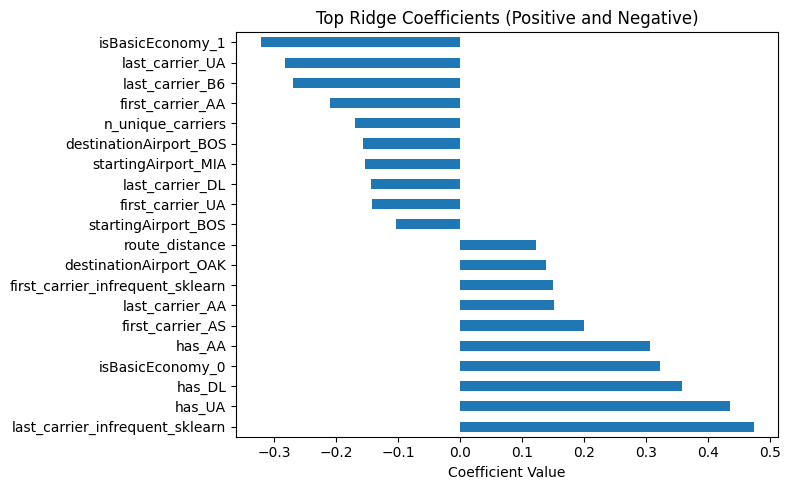

In [88]:
import matplotlib.pyplot as plt

top_features = pd.concat([coefs_sorted.head(10), coefs_sorted.tail(10)])
plt.figure(figsize=(8,5))
top_features.plot(kind='barh')
plt.title("Top Ridge Coefficients (Positive and Negative)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()


In [89]:
summary = pd.DataFrame({
    'feature': feature_names,
    'coef': ridge_model.coef_
}).sort_values('coef', ascending=False)

summary.head(10), summary.tail(10)


(                             feature      coef
 68   last_carrier_infrequent_sklearn  0.473110
 7                             has_UA  0.435240
 8                             has_DL  0.358448
 51                  isBasicEconomy_0  0.322097
 6                             has_AA  0.305667
 54                  first_carrier_AS  0.200006
 61                   last_carrier_AA  0.151080
 60  first_carrier_infrequent_sklearn  0.148791
 44            destinationAirport_OAK  0.138746
 1                     route_distance  0.121419,
                    feature      coef
 17     startingAirport_BOS -0.103549
 59        first_carrier_UA -0.142295
 64         last_carrier_DL -0.144636
 27     startingAirport_MIA -0.154113
 33  destinationAirport_BOS -0.156552
 4        n_unique_carriers -0.169499
 53        first_carrier_AA -0.210185
 63         last_carrier_B6 -0.270570
 67         last_carrier_UA -0.282695
 52        isBasicEconomy_1 -0.322097)